In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

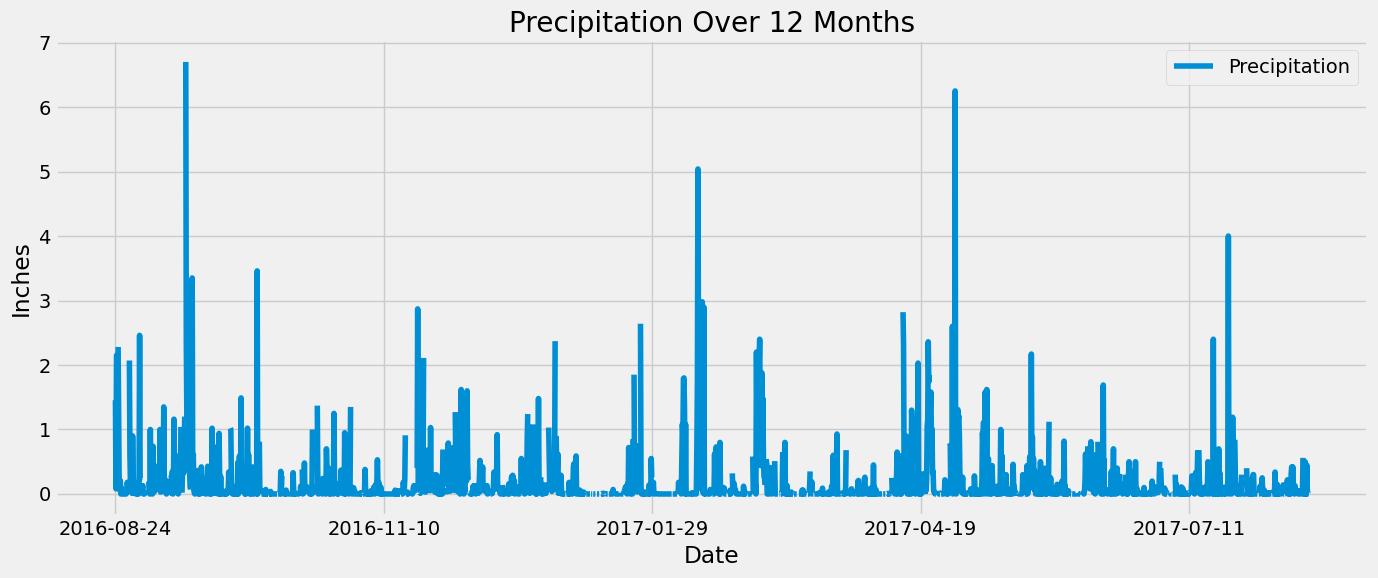

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
conv_recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year = conv_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).\
    filter(measurement.date <= conv_recent_date).\
    filter(measurement.date > one_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_query, columns=['date', 'Precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_sorted = prcp_df.sort_values('date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_sorted.plot(figsize=(14,6))
plt.title('Precipitation Over 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station.station).count()
station_count

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
# List the stations and their counts in descending order.
active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Count'])
active_stations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

summary = session.query(func.avg(measurement.tobs), func.min(measurement.tobs), func.max(measurement.tobs)).\
    filter(measurement.station == most_active).all()

summary

[(71.66378066378067, 54.0, 85.0)]

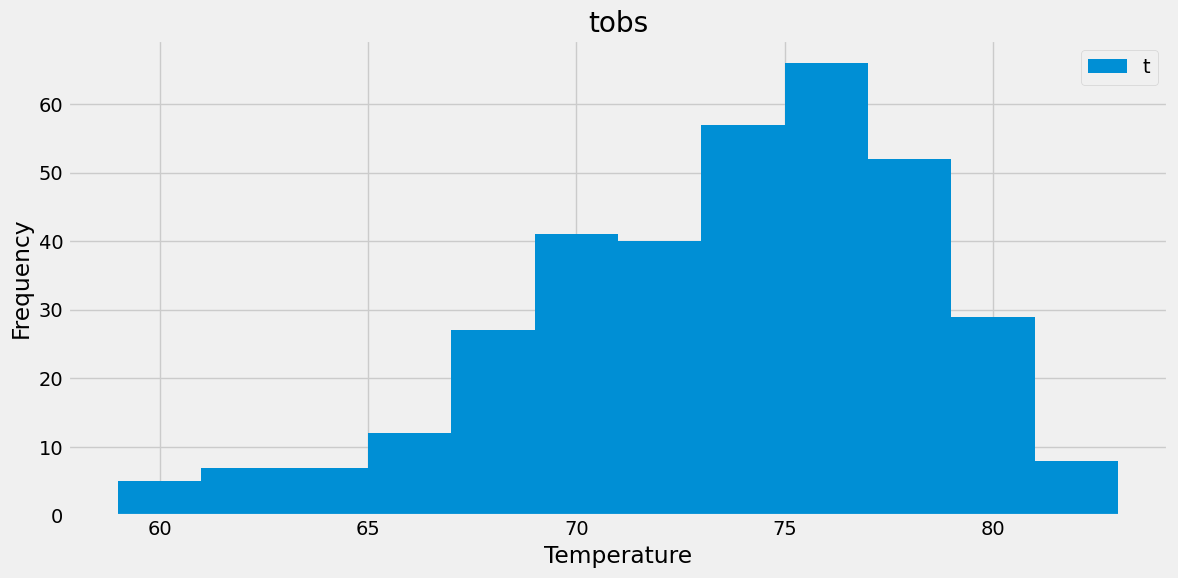

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(measurement.date, measurement.tobs).order_by(measurement.date.desc()).\
    filter(measurement.station == most_active).\
    filter(measurement.date <= conv_recent_date).\
    filter(measurement.date > one_year).all()

# Save the query results as a Pandas DF and set the index to the date column
tobs_df = pd.DataFrame(tobs_query, columns=['date', 'tobs'])
tobs_df.set_index('date')

#Plot results as a histogram
tobs_df.hist(bins=12, figsize=(12,6))
plt.legend('Temp. Observation')
plt.legend('tobs', bbox_to_anchor=(1, 1), loc=1)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()


# Close Session

In [17]:
# Close Session
session.close()